### Imports

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import Actions

from stable_baselines3 import A2C

import quantstats as qs

### Create Env

In [3]:
df = gym_anytrading.datasets.STOCKS_GOOGL.copy()

window_size = 10
start_index = window_size
end_index = len(df)

env = gym.make(
    'stocks-v0',
    df=df,
    window_size=window_size,
    frame_bound=(start_index, end_index)
)



observation_space: Box(-10000000000.0, 10000000000.0, (10, 2), float32)


In [ ]:
print("observation_space:", env.observation_space)

### Train Env

In [4]:
env.reset(seed=2023)
model = A2C('MlpPolicy', env, verbose=0)
model.learn(total_timesteps=1_000)

### Test Env

In [5]:
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

observation, info = env.reset(seed=2023)

while True:
    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)

action_stats: {<Actions.Sell: 0>: 1228, <Actions.Buy: 1>: 1096}
info: {'total_reward': 509.2998504638672, 'total_profit': 0.0004647836453418036, 'position': <Positions.Short: 0>}


### Plot Results

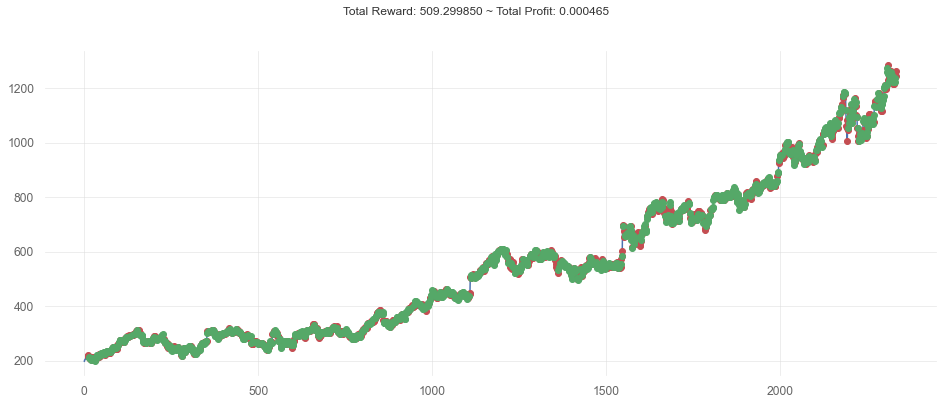

In [6]:
plt.figure(figsize=(16, 6))
env.unwrapped.render_all()
plt.show()

### Analysis Using `quantstats`

                           Strategy
-------------------------  ----------
Start Period               2009-06-10
End Period                 2018-08-29
Risk-Free Rate             0.0%
Time in Market             25.0%

Cumulative Return          -99.95%
CAGR﹪                     -43.69%

Sharpe                     -4.4
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -4.07
Sortino                    -4.58
Smart Sortino              -4.24
Sortino/√2                 -3.24
Smart Sortino/√2           -3.0
Omega                      0.17

Max Drawdown               -99.95%
Longest DD Days            3366
Volatility (ann.)          18.5%
Calmar                     -0.44
Skew                       -2.15
Kurtosis                   20.09

Expected Daily %           -0.33%
Expected Monthly %         -6.68%
Expected Yearly %          -53.58%
Kelly Criterion            -104.23%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.24%
Expected Shortfall (cVaR)  -2.24%

Max Consecuti

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2009-06-12,2018-08-21,2018-08-29,3366,-99.954113,-99.950875


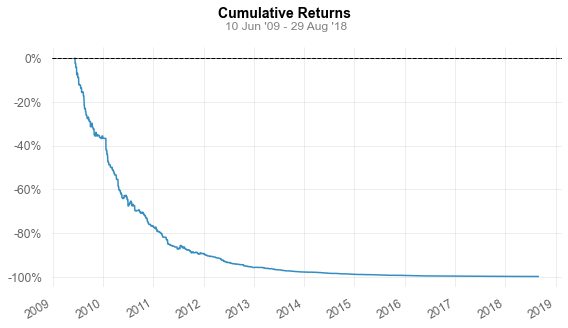

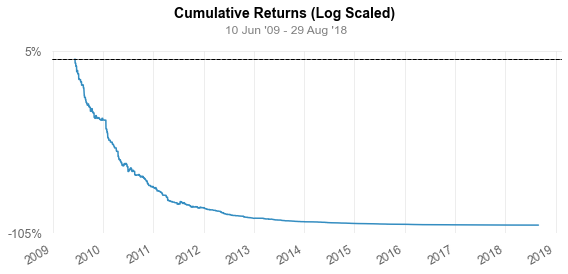

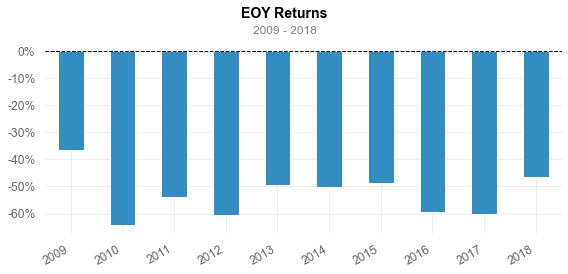

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

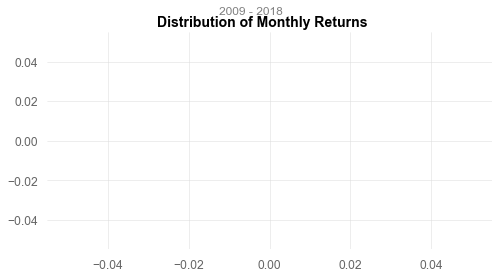

In [7]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='SB3_a2c_quantstats.html')